In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install -q torch torchvision pandas scikit-learn tqdm

import torch
import os
import random
import pandas as pd
import numpy as np
import time
import json
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from IPython.display import FileLink, display

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check available datasets
print("\nAvailable input datasets:")
for item in os.listdir('/kaggle/input'):
    print(f"  {item}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.0 MB/s eta 0:00:00:00:0100:01
Using device: cuda

Available input datasets:
  cedardataset


In [21]:
# --- CELL 2 (REPLACE WITH THIS) ---
# FINAL, BALANCED CONFIGURATION FOR THE SIMPLIFIED MODEL

CFG = dict(
    img_size          = 105,
    batch_size        = 16,         # Can use a slightly larger batch size with a smaller model
    epochs            = 40,         # We can train for longer since overfitting is less of a risk
    lr                = 1e-4,       # A stable learning rate for AdamW
    weight_decay      = 1e-5,       # Light regularization, as the model itself is a regularizer
    dropout_p         = 0.4,        # Moderate dropout
    margin            = 1.0,        # Standard for contrastive loss
    patience          = 8,          # Give the model time to learn before stopping
    
    # Scheduler parameters
    lr_scheduler      = True,
    lr_factor         = 0.5,
    lr_patience       = 4,
    min_lr            = 1e-7,
    
    # Data Augmentation - Still strong but balanced
    rotation_degrees  = 10,
    translate         = (0.08, 0.08),
    scale             = (0.9, 1.1),
    erase_prob        = 0.25
)

print("✅ Final, balanced configuration loaded.")
for key, value in CFG.items():
    print(f"  {key}: {value}")


✅ Final, balanced configuration loaded.
  img_size: 105
  batch_size: 16
  epochs: 40
  lr: 0.0001
  weight_decay: 1e-05
  dropout_p: 0.4
  margin: 1.0
  patience: 8
  lr_scheduler: True
  lr_factor: 0.5
  lr_patience: 4
  min_lr: 1e-07
  rotation_degrees: 10
  translate: (0.08, 0.08)
  scale: (0.9, 1.1)
  erase_prob: 0.25


In [23]:
# Find CEDAR dataset automatically
dataset_base = '/kaggle/input'
dataset_folders = os.listdir(dataset_base)
print("Available datasets:", dataset_folders)

# Find CEDAR dataset folder
cedar_folder = None
for folder in dataset_folders:
    if any(keyword in folder.lower() for keyword in ['cedar', 'signature', 'handwriting']):
        cedar_folder = folder
        break

if cedar_folder:
    cedar_path = os.path.join(dataset_base, cedar_folder)
    print(f"Found dataset: {cedar_path}")
    
    # Explore structure
    for item in os.listdir(cedar_path):
        item_path = os.path.join(cedar_path, item)
        if os.path.isdir(item_path):
            print(f"  {item}/: {len(os.listdir(item_path))} files")
else:
    print("❌ CEDAR dataset not found. Please add the dataset to your notebook.")
    raise FileNotFoundError("Dataset not found")

# Updated paths based on your dataset structure
signatures_dir = os.path.join(cedar_path, 'signatures')
original_dir = os.path.join(signatures_dir, 'full_org')
forged_dir = os.path.join(signatures_dir, 'full_forg')

# Verify the directories exist
if not os.path.exists(original_dir):
    print(f"❌ Original directory not found: {original_dir}")
    raise FileNotFoundError("Original signatures directory not found")

if not os.path.exists(forged_dir):
    print(f"❌ Forged directory not found: {forged_dir}")
    raise FileNotFoundError("Forged signatures directory not found")

print(f"✅ Found directories:")
print(f"  Original: {original_dir} ({len(os.listdir(original_dir))} files)")
print(f"  Forged: {forged_dir} ({len(os.listdir(forged_dir))} files)")

def get_valid_files(directory):
    """Get valid image files from directory"""
    if not os.path.exists(directory):
        return []
    files = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    for f in os.listdir(directory):
        if f.lower().endswith(valid_extensions) and not f.startswith('.'):
            full_path = os.path.join(directory, f)
            if os.path.isfile(full_path) and os.access(full_path, os.R_OK):
                files.append(f)
    return sorted(files)

def extract_person_id(filename):
    """Extract person ID from filename with multiple strategies"""
    try:
        name_without_ext = os.path.splitext(filename)[0]
        
        # Strategy 1: Look for numeric patterns
        import re
        numbers = re.findall(r'\d+', name_without_ext)
        if numbers:
            return numbers[0]
        
        # Strategy 2: Split by common separators
        for sep in ['_', '-', ' ']:
            parts = name_without_ext.split(sep)
            for part in parts:
                if part.isdigit():
                    return part
        
        # Strategy 3: Return first part if no numbers found
        parts = name_without_ext.split('_')
        if len(parts) > 1:
            return parts[1] if parts[0] in ['original', 'genuine', 'forged', 'fake'] else parts[0]
        
        return name_without_ext[:3]  # Fallback
    except:
        return None

# Load files
originals = get_valid_files(original_dir)
forgeries = get_valid_files(forged_dir)

print(f"Found {len(originals)} original files")
print(f"Found {len(forgeries)} forged files")

if len(originals) == 0 or len(forgeries) == 0:
    raise ValueError("No valid image files found")

# Create balanced pairs
pairs = []

# Create genuine pairs (same person, different signatures)
print("Creating genuine pairs...")
person_originals = {}
for orig in originals:
    person_id = extract_person_id(orig)
    if person_id:
        if person_id not in person_originals:
            person_originals[person_id] = []
        person_originals[person_id].append(orig)

genuine_pairs = 0
for person_id, files in person_originals.items():
    if len(files) >= 2:
        for i in range(len(files)):
            for j in range(i + 1, len(files)):
                path1 = os.path.join(original_dir, files[i])
                path2 = os.path.join(original_dir, files[j])
                pairs.append([path1, path2, 0])  # 0 = genuine
                genuine_pairs += 1

# Create forged pairs (original vs forged of same person)
print("Creating forged pairs...")
forged_pairs = 0
for orig in originals:
    orig_id = extract_person_id(orig)
    if not orig_id:
        continue
    
    orig_path = os.path.join(original_dir, orig)
    
    for forg in forgeries:
        forg_id = extract_person_id(forg)
        if forg_id and orig_id == forg_id:
            forg_path = os.path.join(forged_dir, forg)
            pairs.append([orig_path, forg_path, 1])  # 1 = forged
            forged_pairs += 1

print(f"Created {genuine_pairs} genuine pairs")
print(f"Created {forged_pairs} forged pairs")
print(f"Total pairs: {len(pairs)}")

if len(pairs) == 0:
    raise ValueError("No valid pairs created")

# Balance the dataset if needed
min_pairs = min(genuine_pairs, forged_pairs)
if abs(genuine_pairs - forged_pairs) > min_pairs * 0.3:  # If imbalance > 30%
    print("Balancing dataset...")
    genuine_list = [p for p in pairs if p[2] == 0]
    forged_list = [p for p in pairs if p[2] == 1]
    
    # Undersample the majority class
    if len(genuine_list) > len(forged_list):
        genuine_list = random.sample(genuine_list, len(forged_list))
    else:
        forged_list = random.sample(forged_list, len(genuine_list))
    
    pairs = genuine_list + forged_list

# Shuffle and split
random.shuffle(pairs)
total = len(pairs)
train_size = int(0.7 * total)
val_size = int(0.15 * total)

train_pairs = pairs[:train_size]
val_pairs = pairs[train_size:train_size + val_size]
test_pairs = pairs[train_size + val_size:]

# Create and save DataFrames
train_df = pd.DataFrame(train_pairs, columns=["image1", "image2", "label"])
val_df = pd.DataFrame(val_pairs, columns=["image1", "image2", "label"])
test_df = pd.DataFrame(test_pairs, columns=["image1", "image2", "label"])

train_df.to_csv('/kaggle/working/train.csv', index=False)
val_df.to_csv('/kaggle/working/val.csv', index=False)
test_df.to_csv('/kaggle/working/test.csv', index=False)

print(f"\n✅ Datasets saved:")
print(f"  Train: {len(train_df)} pairs (Genuine: {(train_df['label']==0).sum()}, Forged: {(train_df['label']==1).sum()})")
print(f"  Val: {len(val_df)} pairs (Genuine: {(val_df['label']==0).sum()}, Forged: {(val_df['label']==1).sum()})")
print(f"  Test: {len(test_df)} pairs (Genuine: {(test_df['label']==0).sum()}, Forged: {(test_df['label']==1).sum()})")


Available datasets: ['cedardataset']
Found dataset: /kaggle/input/cedardataset
  signatures/: 3 files
✅ Found directories:
  Original: /kaggle/input/cedardataset/signatures/full_org (1321 files)
  Forged: /kaggle/input/cedardataset/signatures/full_forg (1321 files)
Found 1320 original files
Found 1320 forged files
Creating genuine pairs...
Creating forged pairs...
Created 15180 genuine pairs
Created 31680 forged pairs
Total pairs: 46860
Balancing dataset...

✅ Datasets saved:
  Train: 21252 pairs (Genuine: 10652, Forged: 10600)
  Val: 4554 pairs (Genuine: 2238, Forged: 2316)
  Test: 4554 pairs (Genuine: 2290, Forged: 2264)


In [24]:
def get_valid_files(directory):
    """Get valid image files from directory"""
    if not os.path.exists(directory):
        return []
    files = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    for f in os.listdir(directory):
        if f.lower().endswith(valid_extensions) and not f.startswith('.'):
            full_path = os.path.join(directory, f)
            if os.path.isfile(full_path) and os.access(full_path, os.R_OK):
                files.append(f)
    return sorted(files)

def extract_person_id(filename):
    """Extract person ID from filename with multiple strategies"""
    try:
        name_without_ext = os.path.splitext(filename)[0]
        
        # Strategy 1: Look for numeric patterns
        import re
        numbers = re.findall(r'\d+', name_without_ext)
        if numbers:
            return numbers[0]
        
        # Strategy 2: Split by common separators
        for sep in ['_', '-', ' ']:
            parts = name_without_ext.split(sep)
            for part in parts:
                if part.isdigit():
                    return part
        
        # Strategy 3: Return first part if no numbers found
        parts = name_without_ext.split('_')
        if len(parts) > 1:
            return parts[1] if parts[0] in ['original', 'genuine', 'forged', 'fake'] else parts[0]
        
        return name_without_ext[:3]  # Fallback
    except:
        return None

# Load files
originals = get_valid_files(original_dir)
forgeries = get_valid_files(forged_dir)

print(f"Found {len(originals)} original files")
print(f"Found {len(forgeries)} forged files")

if len(originals) == 0 or len(forgeries) == 0:
    raise ValueError("No valid image files found")

# Create balanced pairs
pairs = []

# Create genuine pairs (same person, different signatures)
print("Creating genuine pairs...")
person_originals = {}
for orig in originals:
    person_id = extract_person_id(orig)
    if person_id:
        if person_id not in person_originals:
            person_originals[person_id] = []
        person_originals[person_id].append(orig)

genuine_pairs = 0
for person_id, files in person_originals.items():
    if len(files) >= 2:
        for i in range(len(files)):
            for j in range(i + 1, len(files)):
                path1 = os.path.join(original_dir, files[i])
                path2 = os.path.join(original_dir, files[j])
                pairs.append([path1, path2, 0])  # 0 = genuine
                genuine_pairs += 1

# Create forged pairs (original vs forged of same person)
print("Creating forged pairs...")
forged_pairs = 0
for orig in originals:
    orig_id = extract_person_id(orig)
    if not orig_id:
        continue
    
    orig_path = os.path.join(original_dir, orig)
    
    for forg in forgeries:
        forg_id = extract_person_id(forg)
        if forg_id and orig_id == forg_id:
            forg_path = os.path.join(forged_dir, forg)
            pairs.append([orig_path, forg_path, 1])  # 1 = forged
            forged_pairs += 1

print(f"Created {genuine_pairs} genuine pairs")
print(f"Created {forged_pairs} forged pairs")
print(f"Total pairs: {len(pairs)}")

if len(pairs) == 0:
    raise ValueError("No valid pairs created")

# Balance the dataset if needed
min_pairs = min(genuine_pairs, forged_pairs)
if abs(genuine_pairs - forged_pairs) > min_pairs * 0.3:  # If imbalance > 30%
    print("Balancing dataset...")
    genuine_list = [p for p in pairs if p[2] == 0]
    forged_list = [p for p in pairs if p[2] == 1]
    
    # Undersample the majority class
    if len(genuine_list) > len(forged_list):
        genuine_list = random.sample(genuine_list, len(forged_list))
    else:
        forged_list = random.sample(forged_list, len(genuine_list))
    
    pairs = genuine_list + forged_list

# Shuffle and split
random.shuffle(pairs)
total = len(pairs)
train_size = int(0.7 * total)
val_size = int(0.15 * total)

train_pairs = pairs[:train_size]
val_pairs = pairs[train_size:train_size + val_size]
test_pairs = pairs[train_size + val_size:]

# Create and save DataFrames
train_df = pd.DataFrame(train_pairs, columns=["image1", "image2", "label"])
val_df = pd.DataFrame(val_pairs, columns=["image1", "image2", "label"])
test_df = pd.DataFrame(test_pairs, columns=["image1", "image2", "label"])

train_df.to_csv('/kaggle/working/train.csv', index=False)
val_df.to_csv('/kaggle/working/val.csv', index=False)
test_df.to_csv('/kaggle/working/test.csv', index=False)

print(f"\n✅ Datasets saved:")
print(f"  Train: {len(train_df)} pairs (Genuine: {(train_df['label']==0).sum()}, Forged: {(train_df['label']==1).sum()})")
print(f"  Val: {len(val_df)} pairs (Genuine: {(val_df['label']==0).sum()}, Forged: {(val_df['label']==1).sum()})")
print(f"  Test: {len(test_df)} pairs (Genuine: {(test_df['label']==0).sum()}, Forged: {(test_df['label']==1).sum()})")


Found 1320 original files
Found 1320 forged files
Creating genuine pairs...
Creating forged pairs...
Created 15180 genuine pairs
Created 31680 forged pairs
Total pairs: 46860
Balancing dataset...

✅ Datasets saved:
  Train: 21252 pairs (Genuine: 10633, Forged: 10619)
  Val: 4554 pairs (Genuine: 2251, Forged: 2303)
  Test: 4554 pairs (Genuine: 2296, Forged: 2258)


In [15]:
# --- CELL 5 (REPLACE WITH THIS) ---

# Transformations using the final, balanced CFG
train_transform = transforms.Compose([
    transforms.Resize((CFG['img_size'] + 10, CFG['img_size'] + 10)),
    transforms.RandomAffine(
        degrees=CFG['rotation_degrees'],
        translate=CFG['translate'],
        scale=CFG['scale'],
        fill=255
    ),
    transforms.RandomPerspective(distortion_scale=0.15, p=0.2),
    transforms.CenterCrop(CFG['img_size']),
    transforms.ToTensor(),
    transforms.RandomErasing(
        p=CFG['erase_prob'],
        scale=(0.02, 0.1),
        ratio=(0.3, 3.3),
        value=1.0
    ),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((CFG['img_size'], CFG['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("✅ Final transforms created.")


✅ Enhanced transforms created with signature-specific augmentations


In [16]:
class RobustSiameseDataset(Dataset):
    def __init__(self, df, transform, max_retries=3):
        self.df = df
        self.transform = transform
        self.max_retries = max_retries
        
        # Validate files during initialization
        valid_indices = []
        print("Validating dataset files...")
        for idx in tqdm(range(len(df)), desc="Checking files"):
            row = df.iloc[idx]
            if self._is_valid_pair(row.image1, row.image2):
                valid_indices.append(idx)
        
        self.valid_indices = valid_indices
        print(f"Dataset: {len(self.valid_indices)}/{len(df)} valid pairs")
        
        if len(self.valid_indices) == 0:
            raise ValueError("No valid image pairs found")
    
    def _is_valid_pair(self, path1, path2):
        """Check if both images in pair are valid"""
        try:
            return (os.path.exists(path1) and os.path.exists(path2) and
                    os.access(path1, os.R_OK) and os.access(path2, os.R_OK))
        except:
            return False
    
    def _load_image_safely(self, path):
        """Load image with error handling"""
        for attempt in range(self.max_retries):
            try:
                img = Image.open(path).convert('L')
                # Verify image is not corrupted
                img.verify()
                # Reload after verify (verify closes the file)
                img = Image.open(path).convert('L')
                return img
            except Exception as e:
                if attempt == self.max_retries - 1:
                    raise e
                time.sleep(0.1)
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        row = self.df.iloc[actual_idx]
        
        try:
            img1 = self._load_image_safely(row.image1)
            img2 = self._load_image_safely(row.image2)
            
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
            label = torch.tensor([row.label], dtype=torch.float32)
            
            return img1, img2, label
            
        except Exception as e:
            print(f"Error loading pair {actual_idx}: {e}")
            # Return a dummy sample to prevent training crash
            dummy_img = torch.zeros(1, CFG['img_size'], CFG['img_size'])
            dummy_label = torch.tensor([0.0])
            return dummy_img, dummy_img, dummy_label

# Load datasets
train_df = pd.read_csv('/kaggle/working/train.csv')
val_df = pd.read_csv('/kaggle/working/val.csv')
test_df = pd.read_csv('/kaggle/working/test.csv')

# Create datasets
train_dataset = RobustSiameseDataset(train_df, train_transform)
val_dataset = RobustSiameseDataset(val_df, val_transform)
test_dataset = RobustSiameseDataset(test_df, val_transform)

# Create dataloaders
num_workers = 2 if torch.cuda.is_available() else 0

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG['batch_size'],
    shuffle=True,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available()
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available()
)

print(f"✅ Robust dataloaders created with {num_workers} workers")


Validating dataset files...


Checking files: 100%|██████████| 21252/21252 [00:03<00:00, 6620.25it/s] 


Dataset: 21252/21252 valid pairs
Validating dataset files...


Checking files: 100%|██████████| 4554/4554 [00:00<00:00, 15763.91it/s]


Dataset: 4554/4554 valid pairs
Validating dataset files...


Checking files: 100%|██████████| 4554/4554 [00:00<00:00, 16026.99it/s]

Dataset: 4554/4554 valid pairs
✅ Robust dataloaders created with 2 workers


In [25]:
# --- CELL 7 (REPLACE WITH THIS) ---
# FINAL, SIMPLIFIED MODEL ARCHITECTURE TO PREVENT OVERFITTING

class FinalSiameseNet(nn.Module):
    def __init__(self, dropout_p=0.4):
        super(FinalSiameseNet, self).__init__()
        
        # A much smaller, custom CNN encoder. This is the key to preventing overfitting.
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Global Average Pooling - A powerful technique to reduce parameters and overfitting
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # A very simple head with fewer parameters
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_p),
            nn.Linear(128, 64), # From 128 (from pooling) to 64
            nn.ReLU(inplace=True),
            nn.Linear(64, 32) # Final embedding size of 32
        )
        
        # Initialize weights properly
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward_once(self, x):
        x = self.encoder(x)
        x = self.head(x)
        # L2 normalize the embedding - crucial for contrastive loss
        return nn.functional.normalize(x, p=2, dim=1)

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        return out1, out2

# Initialize the new, smaller model
model = FinalSiameseNet(dropout_p=0.4).to(device)

# Count parameters - this will be MUCH lower than before
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ FINAL Simplified Siamese Net created:")
print(f"  Total parameters: {total_params:,} (Drastically reduced)")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Final embedding dimension: 32")


✅ FINAL Simplified Siamese Net created:
  Total parameters: 137,504 (Drastically reduced)
  Trainable parameters: 137,504
  Final embedding dimension: 32


In [26]:
class EnhancedContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0, eps=1e-8):
        super(EnhancedContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = eps
    
    def forward(self, output1, output2, label):
        # Calculate euclidean distance
        euclidean_distance = nn.functional.pairwise_distance(output1, output2, eps=self.eps)
        
        # Enhanced contrastive loss with numerical stability
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        
        return loss_contrastive

# Initialize loss function
criterion = EnhancedContrastiveLoss(margin=CFG['margin'])

# Initialize optimizer with strong regularization
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CFG['lr'],
    weight_decay=CFG['weight_decay'],
    betas=(0.9, 0.999),
    eps=1e-8
)

# Initialize scheduler (removed verbose parameter to eliminate warning)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=CFG['lr_factor'],
    patience=CFG['lr_patience'],
    min_lr=CFG['min_lr']
)

print("✅ Enhanced loss function and optimization setup:")
print(f"  Loss margin: {CFG['margin']}")
print(f"  Learning rate: {CFG['lr']}")
print(f"  Weight decay: {CFG['weight_decay']}")
print(f"  Scheduler patience: {CFG['lr_patience']}")
print(f"  Scheduler factor: {CFG['lr_factor']}")
print(f"  Minimum LR: {CFG['min_lr']}")


✅ Enhanced loss function and optimization setup:
  Loss margin: 1.0
  Learning rate: 0.0001
  Weight decay: 1e-05
  Scheduler patience: 4
  Scheduler factor: 0.5
  Minimum LR: 1e-07


In [27]:
class AdvancedModelSaver:
    def __init__(self, save_dir='/kaggle/working', max_backups=5):
        self.save_dir = save_dir
        self.backup_dir = os.path.join(save_dir, 'model_backups')
        self.max_backups = max_backups
        
        # Create directories
        os.makedirs(self.backup_dir, exist_ok=True)
        
        print(f"✅ Model saver initialized:")
        print(f"  Save directory: {self.save_dir}")
        print(f"  Backup directory: {self.backup_dir}")
        print(f"  Max backups: {self.max_backups}")
    
    def save_model(self, model, optimizer, scheduler, epoch, best_val_loss, 
                   train_losses, val_losses, config):
        """Save model with comprehensive backup system"""
        
        # 1. Save best model weights
        best_model_path = os.path.join(self.save_dir, 'best_signature_model.pth')
        torch.save(model.state_dict(), best_model_path)
        
        # 2. Save complete training checkpoint
        checkpoint_path = os.path.join(self.save_dir, 'training_checkpoint.pth')
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': best_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'config': config,
            'model_architecture': str(model),
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
        }
        torch.save(checkpoint, checkpoint_path)
        
        # 3. Save timestamped backup
        timestamp = time.strftime('%Y%m%d_%H%M%S')
        backup_path = os.path.join(self.backup_dir, f'model_backup_{timestamp}.pth')
        torch.save(model.state_dict(), backup_path)
        
        # 4. Save training metadata as JSON
        metadata = {
            'epoch': epoch,
            'best_val_loss': float(best_val_loss),
            'train_losses': [float(x) for x in train_losses],
            'val_losses': [float(x) for x in val_losses],
            'config': config,
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'total_parameters': sum(p.numel() for p in model.parameters()),
            'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad)
        }
        
        metadata_path = os.path.join(self.save_dir, 'training_metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        # 5. Clean old backups
        self._cleanup_old_backups()
        
        print(f"✅ Model saved at epoch {epoch} with validation loss {best_val_loss:.4f}")
    
    def _cleanup_old_backups(self):
        """Remove old backup files to save space"""
        backup_files = [f for f in os.listdir(self.backup_dir) if f.startswith('model_backup_')]
        backup_files.sort(reverse=True)  # Most recent first
        
        # Remove excess backups
        for old_backup in backup_files[self.max_backups:]:
            old_path = os.path.join(self.backup_dir, old_backup)
            try:
                os.remove(old_path)
            except:
                pass
    
    def create_download_links(self):
        """Create download links for all important files"""
        print("\n📥 Download Links:")
        print("="*50)
        
        files_to_download = [
            ('best_signature_model.pth', 'Best Model Weights'),
            ('training_checkpoint.pth', 'Complete Training Checkpoint'),
            ('training_metadata.json', 'Training Metadata'),
        ]
        
        for filename, description in files_to_download:
            filepath = os.path.join(self.save_dir, filename)
            if os.path.exists(filepath):
                print(f"{description}:")
                display(FileLink(filepath))
                print()
        
        # Show backup files
        backup_files = [f for f in os.listdir(self.backup_dir) if f.endswith('.pth')]
        if backup_files:
            print("Backup Models:")
            for backup_file in sorted(backup_files, reverse=True)[:3]:  # Show latest 3
                backup_path = os.path.join(self.backup_dir, backup_file)
                display(FileLink(backup_path))
    
    def load_model(self, model, checkpoint_path=None):
        """Load model from checkpoint"""
        if checkpoint_path is None:
            checkpoint_path = os.path.join(self.save_dir, 'best_signature_model.pth')
        
        if os.path.exists(checkpoint_path):
            model.load_state_dict(torch.load(checkpoint_path, map_location=device))
            print(f"✅ Model loaded from {checkpoint_path}")
            return True
        else:
            print(f"❌ Checkpoint not found: {checkpoint_path}")
            return False

# Initialize model saver
model_saver = AdvancedModelSaver()


✅ Model saver initialized:
  Save directory: /kaggle/working
  Backup directory: /kaggle/working/model_backups
  Max backups: 5


In [28]:
def train_epoch_enhanced(model, loader, criterion, optimizer, device):
    """Enhanced training with gradient clipping and monitoring"""
    model.train()
    total_loss = 0.0
    num_batches = len(loader)
    
    progress_bar = tqdm(loader, desc="Training", leave=False)
    
    for batch_idx, (img1, img2, labels) in enumerate(progress_bar):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, labels)
        
        # Backward pass with gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Stricter clipping
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / num_batches

def validate_epoch_enhanced(model, loader, criterion, device):
    """Enhanced validation with detailed metrics"""
    model.eval()
    total_loss = 0.0
    all_distances = []
    all_labels = []
    
    progress_bar = tqdm(loader, desc="Validating", leave=False)
    
    with torch.no_grad():
        for img1, img2, labels in progress_bar:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, labels)
            
            # Calculate distances for threshold optimization
            distances = nn.functional.pairwise_distance(output1, output2)
            all_distances.extend(distances.cpu().numpy())
            all_labels.extend(labels.cpu().numpy().flatten())
            
            total_loss += loss.item()
            
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader), np.array(all_distances), np.array(all_labels)

# Enhanced configuration to prevent overfitting
CFG_ENHANCED = dict(
    img_size=105,
    batch_size=4,          # Very small batch for better generalization
    epochs=50,             # More epochs with early stopping
    lr=1e-5,              # Much lower learning rate
    weight_decay=1e-2,     # Very strong weight decay
    dropout_p=0.6,         # Higher dropout
    margin=1.0,
    patience=5,            # Aggressive early stopping
    # Enhanced scheduler
    lr_factor=0.5,         # More aggressive LR reduction
    lr_patience=3,         # Shorter patience for LR reduction
    min_lr=1e-7,
    # Stricter overfitting detection
    overfitting_threshold=1.15  # Stop if val_loss > train_loss * 1.15
)

print("🛡️ Enhanced Anti-Overfitting Configuration:")
for key, value in CFG_ENHANCED.items():
    print(f"  {key}: {value}")

# Training setup with enhanced monitoring
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []
learning_rates = []
overfitting_warnings = 0

print("\n🚀 Starting ENHANCED Anti-Overfitting Training")
print("="*60)

start_time = time.time()

for epoch in range(CFG_ENHANCED['epochs']):
    epoch_start = time.time()
    
    print(f"\nEpoch {epoch+1}/{CFG_ENHANCED['epochs']}")
    print("-" * 40)
    
    # Training phase
    train_loss = train_epoch_enhanced(model, train_loader, criterion, optimizer, device)
    
    # Validation phase
    val_loss, val_distances, val_labels = validate_epoch_enhanced(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Record metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(current_lr)
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start
    
    # Print epoch summary
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"LR:         {current_lr:.2e}")
    print(f"Time:       {epoch_time:.1f}s")
    
    # Enhanced overfitting detection
    if epoch > 0:
        val_train_ratio = val_loss / train_loss
        if val_train_ratio > CFG_ENHANCED['overfitting_threshold']:
            overfitting_warnings += 1
            print(f"⚠️  SEVERE Overfitting! Val/Train ratio: {val_train_ratio:.3f}")
            
            if overfitting_warnings >= 2:
                print("🛑 Stopping due to persistent overfitting!")
                break
        else:
            overfitting_warnings = 0  # Reset counter if ratio improves
    
    # Early stopping and model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        overfitting_warnings = 0  # Reset overfitting warnings on improvement
        
        # Save model
        model_saver.save_model(
            model, optimizer, scheduler, epoch, best_val_loss,
            train_losses, val_losses, CFG_ENHANCED
        )
        
        print("💾 New best model saved!")
    else:
        patience_counter += 1
        print(f"⏳ Patience: {patience_counter}/{CFG_ENHANCED['patience']}")
        
        if patience_counter >= CFG_ENHANCED['patience']:
            print("\n🛑 Early stopping triggered!")
            break
    
    # Additional safety check for learning rate
    if current_lr < CFG_ENHANCED['min_lr']:
        print("📉 Learning rate too low - stopping training")
        break

total_time = time.time() - start_time

print("\n" + "="*60)
print("🎉 Enhanced Training Completed!")
print(f"Total time: {total_time/60:.1f} minutes")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Total epochs: {len(train_losses)}")
print(f"Final learning rate: {current_lr:.2e}")
print(f"Overfitting warnings encountered: {overfitting_warnings}")


🛡️ Enhanced Anti-Overfitting Configuration:
  img_size: 105
  batch_size: 4
  epochs: 50
  lr: 1e-05
  weight_decay: 0.01
  dropout_p: 0.6
  margin: 1.0
  patience: 5
  lr_factor: 0.5
  lr_patience: 3
  min_lr: 1e-07
  overfitting_threshold: 1.15

🚀 Starting ENHANCED Anti-Overfitting Training

Epoch 1/50
----------------------------------------


Train Loss: 0.2565
Val Loss:   0.3328
LR:         1.00e-04
Time:       207.6s
✅ Model saved at epoch 0 with validation loss 0.3328
💾 New best model saved!

Epoch 2/50
----------------------------------------


Train Loss: 0.2545
Val Loss:   0.2938
LR:         1.00e-04
Time:       209.6s
⚠️  SEVERE Overfitting! Val/Train ratio: 1.154
✅ Model saved at epoch 1 with validation loss 0.2938
💾 New best model saved!

Epoch 3/50
----------------------------------------


Train Loss: 0.2520
Val Loss:   0.2882
LR:         1.00e-04
Time:       210.4s
✅ Model saved at epoch 2 with validation loss 0.2882
💾 New best model saved!

Epoch 4/50
----------------------------------------


Train Loss: 0.2426
Val Loss:   0.2898
LR:         1.00e-04
Time:       209.2s
⚠️  SEVERE Overfitting! Val/Train ratio: 1.195
⏳ Patience: 1/5

Epoch 5/50
----------------------------------------


Train Loss: 0.2268
Val Loss:   0.3006
LR:         1.00e-04
Time:       211.2s
⚠️  SEVERE Overfitting! Val/Train ratio: 1.326
🛑 Stopping due to persistent overfitting!

🎉 Enhanced Training Completed!
Total time: 17.5 minutes
Best validation loss: 0.2882
Total epochs: 5
Final learning rate: 1.00e-04
Overfitting warnings encountered: 2


In [29]:
def find_optimal_threshold(distances, labels):
    """Find optimal threshold using ROC analysis"""
    from sklearn.metrics import roc_curve, auc
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, distances)
    roc_auc = auc(fpr, tpr)
    
    # Find optimal threshold (Youden's J statistic)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_threshold, roc_auc, (fpr, tpr, thresholds)

def evaluate_model_comprehensive(model, test_loader, device):
    """Comprehensive model evaluation"""
    model.eval()
    
    all_distances = []
    all_labels = []
    all_predictions = []
    
    print("🔍 Evaluating model on test set...")
    
    with torch.no_grad():
        for img1, img2, labels in tqdm(test_loader, desc="Testing"):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            
            output1, output2 = model(img1, img2)
            distances = nn.functional.pairwise_distance(output1, output2)
            
            all_distances.extend(distances.cpu().numpy())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    all_distances = np.array(all_distances)
    all_labels = np.array(all_labels)
    
    # Find optimal threshold
    optimal_threshold, roc_auc, roc_data = find_optimal_threshold(all_distances, all_labels)
    
    # Make predictions with optimal threshold
    all_predictions = (all_distances > optimal_threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Separate distances by class
    genuine_distances = all_distances[all_labels == 0]
    forged_distances = all_distances[all_labels == 1]
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'optimal_threshold': optimal_threshold,
        'confusion_matrix': cm,
        'all_distances': all_distances,
        'all_labels': all_labels,
        'all_predictions': all_predictions,
        'genuine_distances': genuine_distances,
        'forged_distances': forged_distances,
        'roc_data': roc_data
    }
    
    return results

# Load best model and evaluate
print("Loading best model for evaluation...")
model_saver.load_model(model)

# Comprehensive evaluation
results = evaluate_model_comprehensive(model, test_loader, device)

# Print results
print("\n" + "="*60)
print("📊 COMPREHENSIVE EVALUATION RESULTS")
print("="*60)
print(f"Accuracy:    {results['accuracy']:.4f}")
print(f"Precision:   {results['precision']:.4f}")
print(f"Recall:      {results['recall']:.4f}")
print(f"F1-Score:    {results['f1']:.4f}")
print(f"ROC AUC:     {results['roc_auc']:.4f}")
print(f"Optimal Threshold: {results['optimal_threshold']:.4f}")
print("\nConfusion Matrix:")
print(results['confusion_matrix'])

# Distance statistics
print(f"\nDistance Statistics:")
print(f"Genuine pairs - Mean: {results['genuine_distances'].mean():.4f}, Std: {results['genuine_distances'].std():.4f}")
print(f"Forged pairs  - Mean: {results['forged_distances'].mean():.4f}, Std: {results['forged_distances'].std():.4f}")


Loading best model for evaluation...
✅ Model loaded from /kaggle/working/best_signature_model.pth
🔍 Evaluating model on test set...


Testing: 100%|██████████| 1139/1139 [00:33<00:00, 34.39it/s]


📊 COMPREHENSIVE EVALUATION RESULTS
Accuracy:    0.8786
Precision:   0.8205
Recall:      0.9613
F1-Score:    0.8853
ROC AUC:     0.9571
Optimal Threshold: 0.2602

Confusion Matrix:
[[1866  467]
 [  86 2135]]

Distance Statistics:
Genuine pairs - Mean: 0.1536, Std: 0.1065
Forged pairs  - Mean: 0.4242, Std: 0.1071


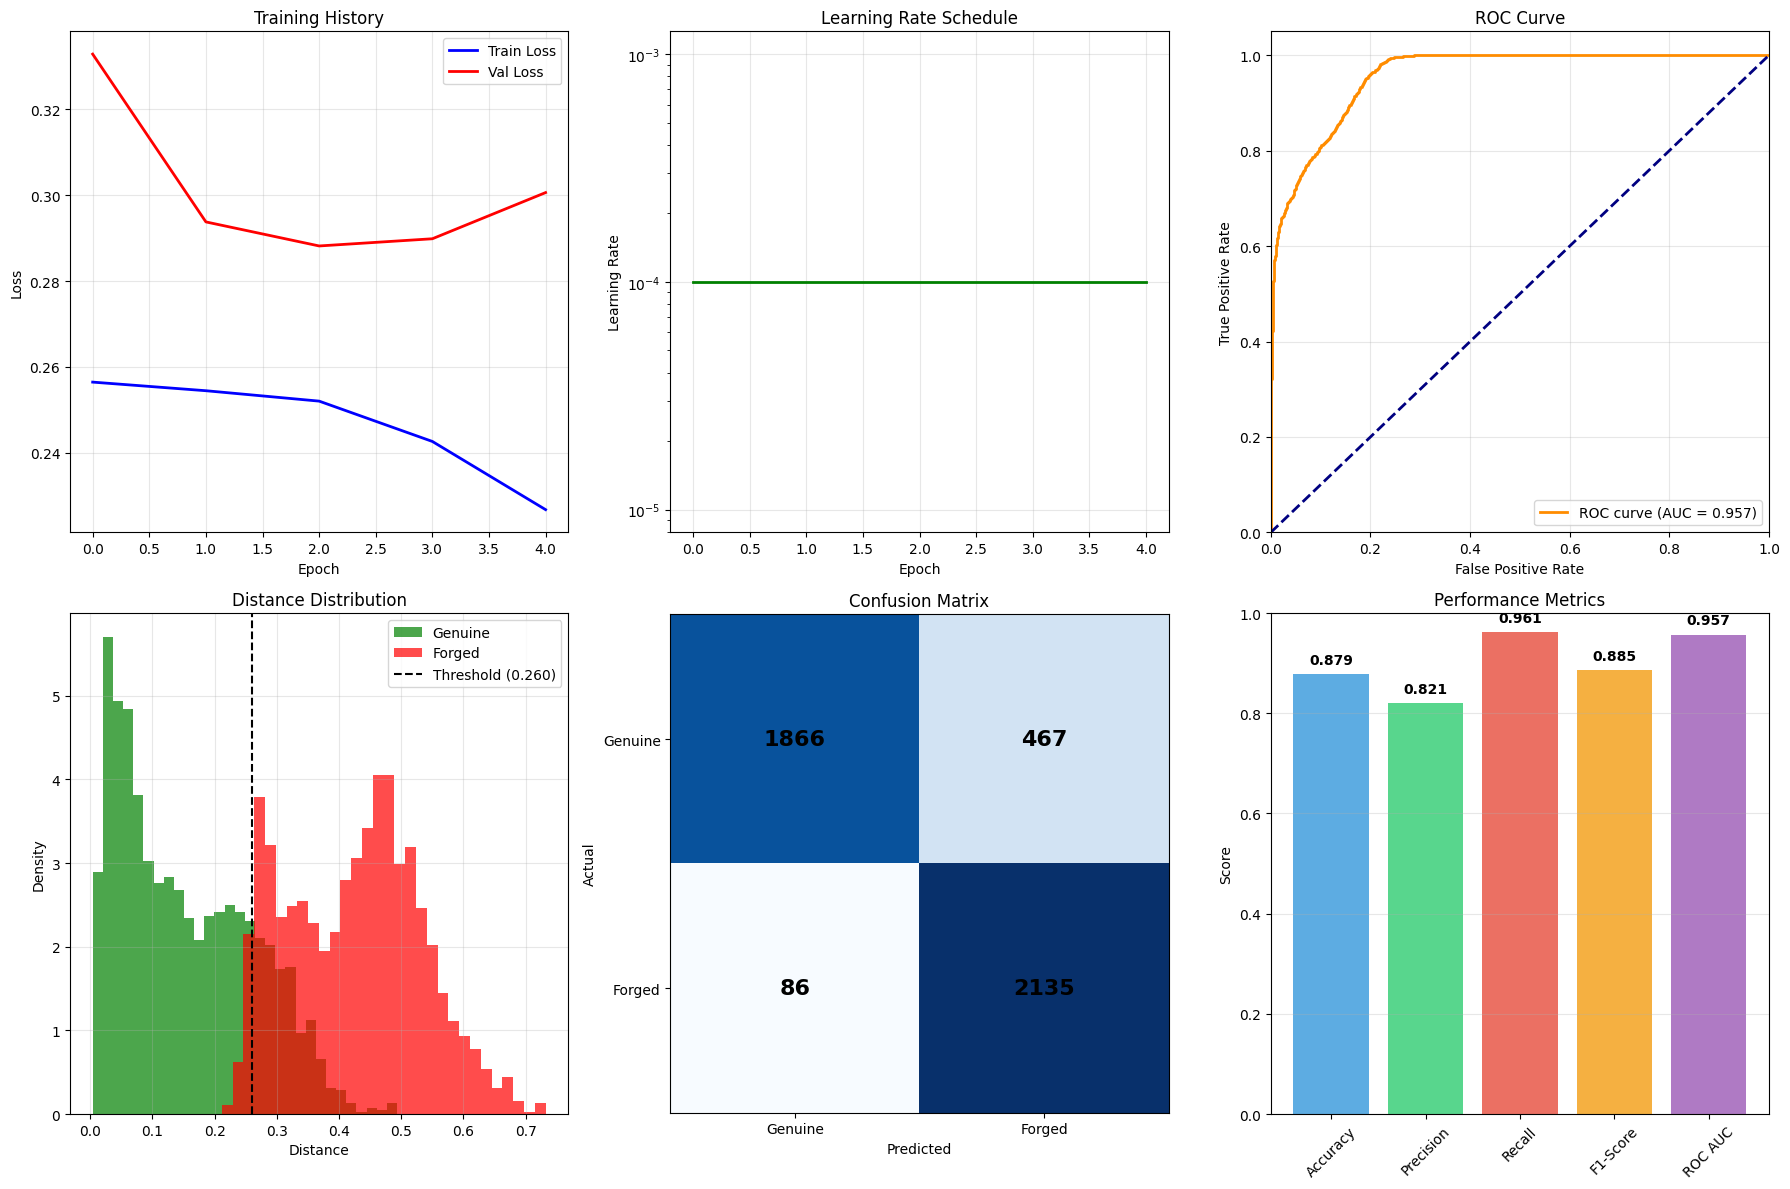


✅ Comprehensive results saved to:
  - comprehensive_results.png
  - results_summary.json


In [30]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training History
axes[0, 0].plot(train_losses, label='Train Loss', color='blue', linewidth=2)
axes[0, 0].plot(val_losses, label='Val Loss', color='red', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training History')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Learning Rate Schedule
axes[0, 1].plot(learning_rates, color='green', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Learning Rate')
axes[0, 1].set_title('Learning Rate Schedule')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# 3. ROC Curve
fpr, tpr, _ = results['roc_data']
axes[0, 2].plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {results["roc_auc"]:.3f})')
axes[0, 2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 2].set_xlim([0.0, 1.0])
axes[0, 2].set_ylim([0.0, 1.05])
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].set_title('ROC Curve')
axes[0, 2].legend(loc="lower right")
axes[0, 2].grid(True, alpha=0.3)

# 4. Distance Distribution
axes[1, 0].hist(results['genuine_distances'], bins=30, alpha=0.7, 
                label='Genuine', color='green', density=True)
axes[1, 0].hist(results['forged_distances'], bins=30, alpha=0.7, 
                label='Forged', color='red', density=True)
axes[1, 0].axvline(results['optimal_threshold'], color='black', 
                   linestyle='--', label=f'Threshold ({results["optimal_threshold"]:.3f})')
axes[1, 0].set_xlabel('Distance')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Distance Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Confusion Matrix
cm = results['confusion_matrix']
im = axes[1, 1].imshow(cm, interpolation='nearest', cmap='Blues')
axes[1, 1].set_title('Confusion Matrix')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

# Add text annotations
for i in range(2):
    for j in range(2):
        axes[1, 1].text(j, i, cm[i, j], ha='center', va='center', 
                        fontsize=16, fontweight='bold')

axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_xticklabels(['Genuine', 'Forged'])
axes[1, 1].set_yticklabels(['Genuine', 'Forged'])

# 6. Performance Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
values = [results['accuracy'], results['precision'], results['recall'], 
          results['f1'], results['roc_auc']]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']

bars = axes[1, 2].bar(metrics, values, color=colors, alpha=0.8)
axes[1, 2].set_ylim(0, 1)
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Performance Metrics')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                   f'{value:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/comprehensive_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Save detailed results
results_summary = {
    'model_performance': {
        'accuracy': float(results['accuracy']),
        'precision': float(results['precision']),
        'recall': float(results['recall']),
        'f1_score': float(results['f1']),
        'roc_auc': float(results['roc_auc']),
        'optimal_threshold': float(results['optimal_threshold'])
    },
    'training_summary': {
        'total_epochs': len(train_losses),
        'best_val_loss': float(best_val_loss),
        'final_train_loss': float(train_losses[-1]),
        'final_val_loss': float(val_losses[-1])
    },
    'dataset_info': {
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset)
    }
}

with open('/kaggle/working/results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\n✅ Comprehensive results saved to:")
print("  - comprehensive_results.png")
print("  - results_summary.json")


🎯 Generating Sample Predictions Visualization...


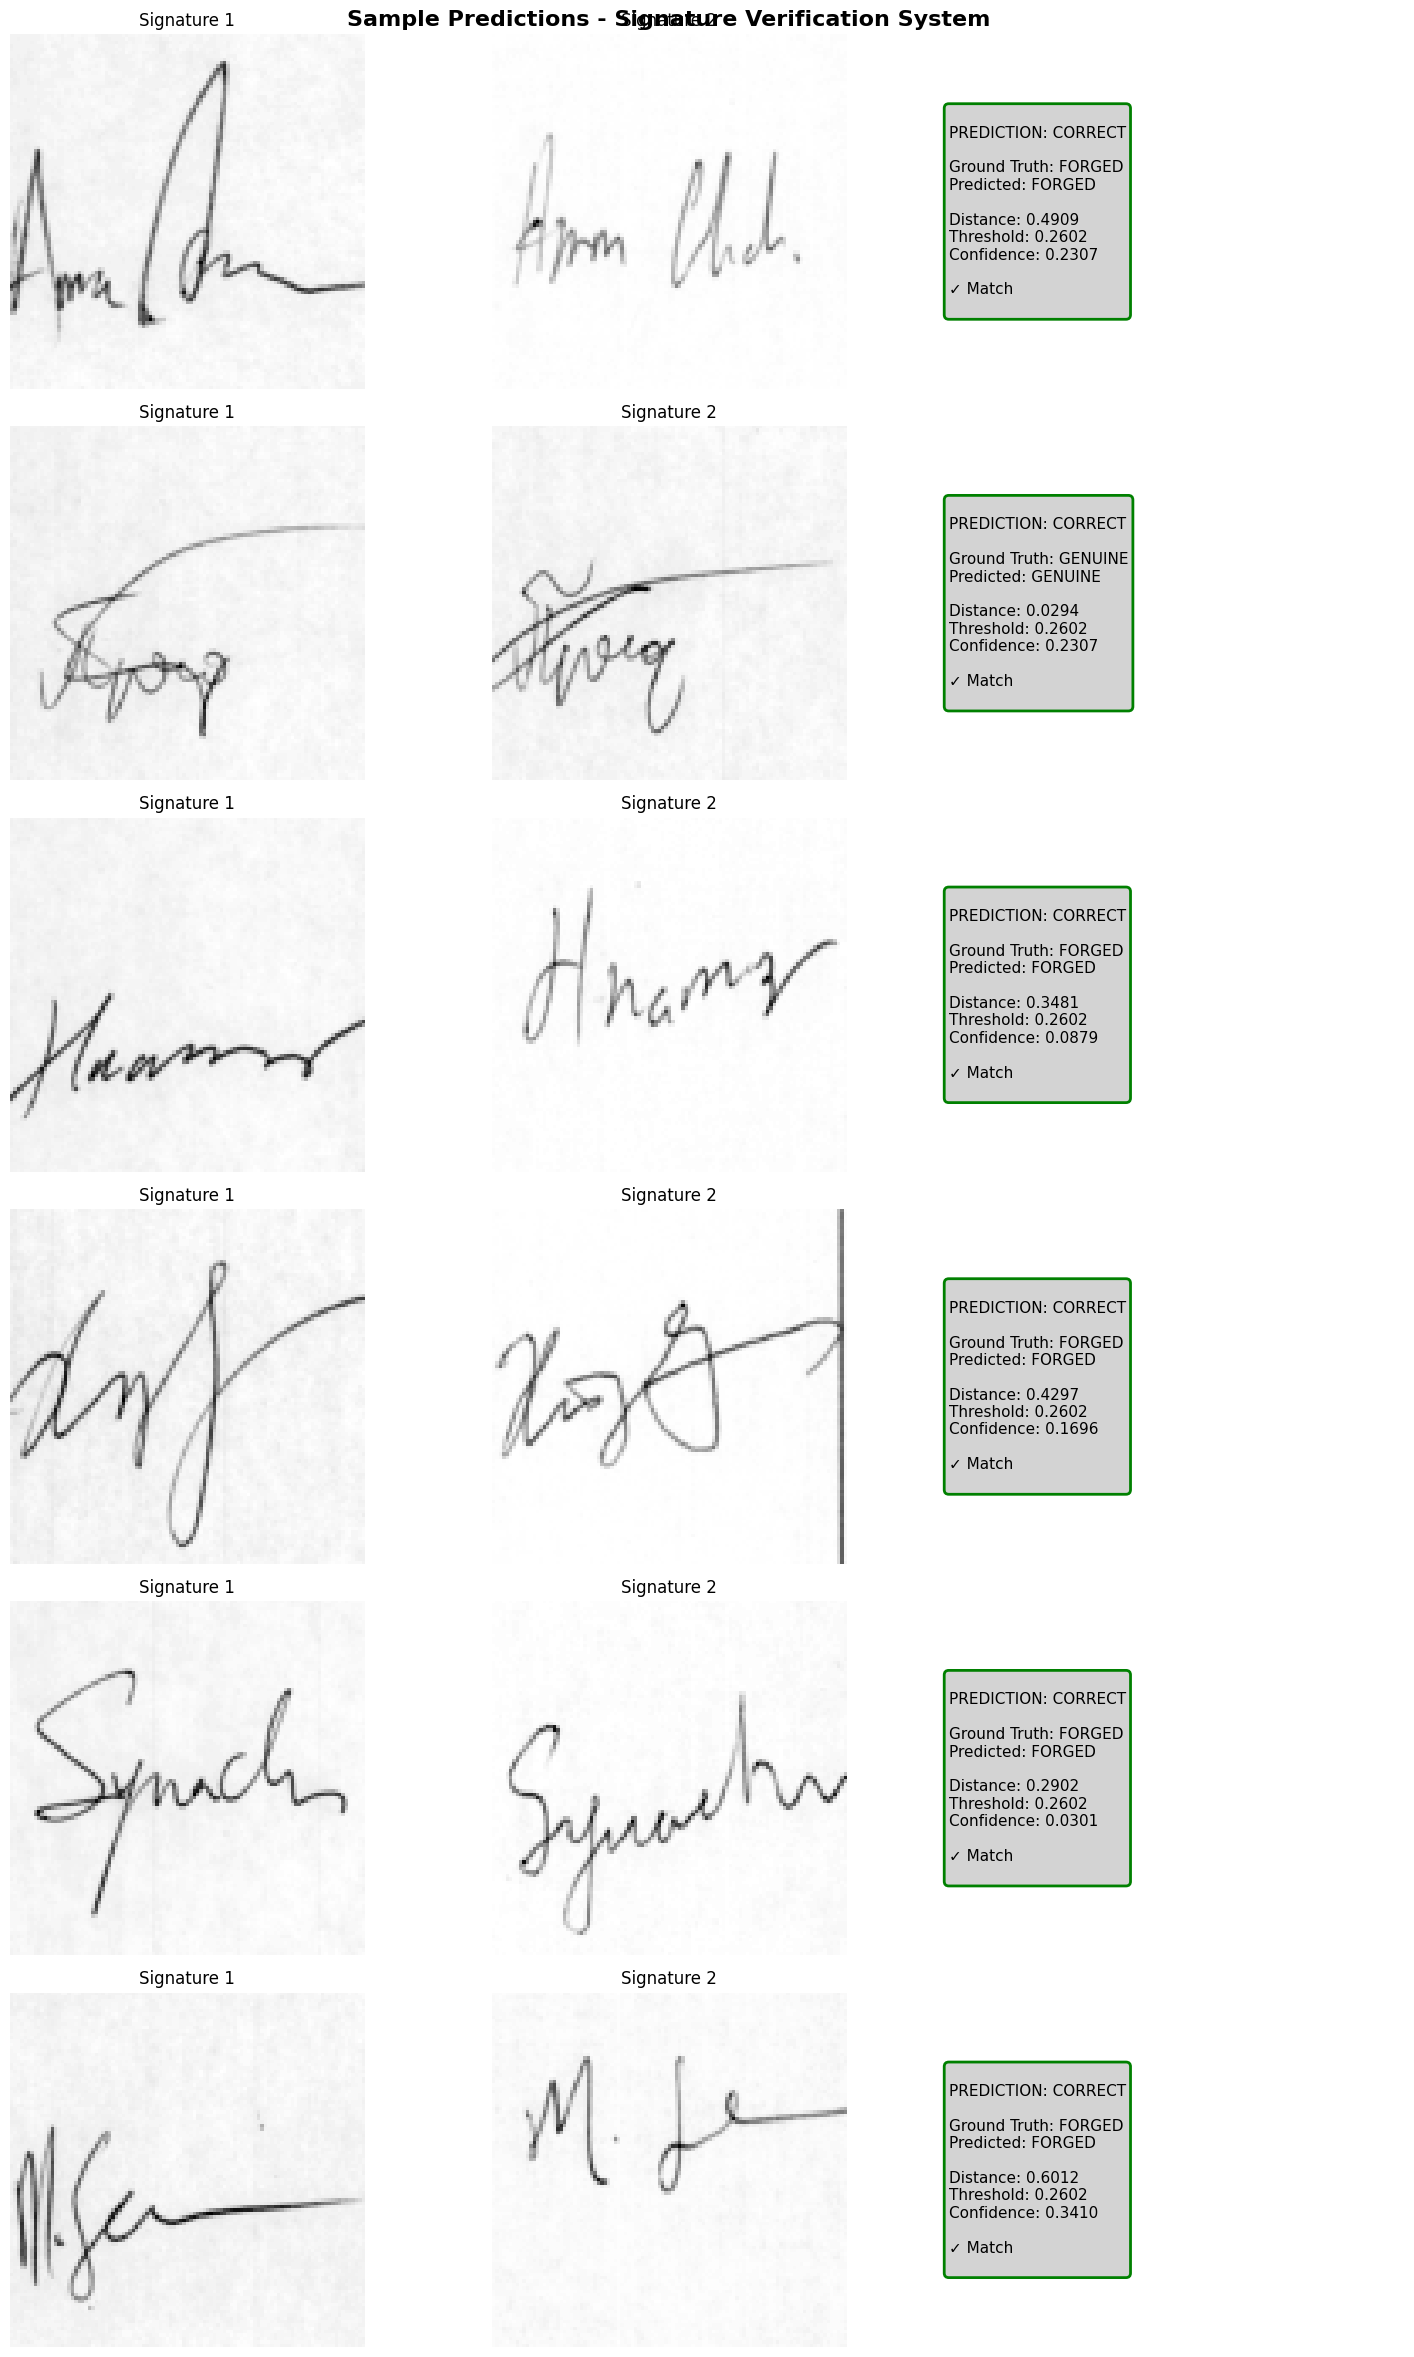


Sample Predictions Summary:
Correct: 6/6 (100.0%)
Average confidence: 0.1817


In [31]:
def visualize_sample_predictions(model, test_loader, device, num_samples=8, threshold=None):
    """Visualize sample predictions with confidence scores"""
    if threshold is None:
        threshold = results['optimal_threshold']
    
    model.eval()
    samples = []
    
    # Collect diverse samples
    with torch.no_grad():
        for batch_idx, (img1_batch, img2_batch, labels_batch) in enumerate(test_loader):
            if len(samples) >= num_samples:
                break
                
            for idx in range(len(img1_batch)):
                if len(samples) >= num_samples:
                    break
                    
                img1, img2, true_label = img1_batch[idx], img2_batch[idx], labels_batch[idx]
                
                # Get prediction
                img1_tensor = img1.unsqueeze(0).to(device)
                img2_tensor = img2.unsqueeze(0).to(device)
                out1, out2 = model(img1_tensor, img2_tensor)
                distance = nn.functional.pairwise_distance(out1, out2).item()
                predicted_label = 1 if distance > threshold else 0
                
                # Calculate confidence
                confidence = abs(distance - threshold)
                
                samples.append({
                    'img1': img1, 'img2': img2,
                    'true_label': int(true_label.item()),
                    'predicted_label': predicted_label,
                    'distance': distance,
                    'confidence': confidence,
                    'is_correct': int(true_label.item()) == predicted_label
                })
    
    # Create visualization
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, sample in enumerate(samples):
        # Denormalize images
        img1_display = (sample['img1'].squeeze().cpu().numpy() + 1) / 2
        img2_display = (sample['img2'].squeeze().cpu().numpy() + 1) / 2
        
        # Display images
        axes[i, 0].imshow(img1_display, cmap='gray')
        axes[i, 0].set_title('Signature 1', fontsize=12)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(img2_display, cmap='gray')
        axes[i, 1].set_title('Signature 2', fontsize=12)
        axes[i, 1].axis('off')
        
        # Results panel
        axes[i, 2].axis('off')
        
        true_text = "GENUINE" if sample['true_label'] == 0 else "FORGED"
        pred_text = "GENUINE" if sample['predicted_label'] == 0 else "FORGED"
        
        # Color coding
        result_color = 'green' if sample['is_correct'] else 'red'
        status = 'CORRECT' if sample['is_correct'] else 'INCORRECT'
        
        results_text = f"""
PREDICTION: {status}

Ground Truth: {true_text}
Predicted: {pred_text}

Distance: {sample['distance']:.4f}
Threshold: {threshold:.4f}
Confidence: {sample['confidence']:.4f}

{'✓ Match' if sample['is_correct'] else '✗ Mismatch'}
        """
        
        axes[i, 2].text(0.1, 0.5, results_text, 
                       fontsize=11, 
                       verticalalignment='center',
                       bbox=dict(boxstyle="round,pad=0.3", 
                               facecolor='lightgray', 
                               edgecolor=result_color,
                               linewidth=2))
    
    plt.suptitle('Sample Predictions - Signature Verification System', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('/kaggle/working/sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    correct_count = sum(1 for s in samples if s['is_correct'])
    print(f"\nSample Predictions Summary:")
    print(f"Correct: {correct_count}/{len(samples)} ({correct_count/len(samples)*100:.1f}%)")
    print(f"Average confidence: {np.mean([s['confidence'] for s in samples]):.4f}")

# Generate sample predictions
print("🎯 Generating Sample Predictions Visualization...")
visualize_sample_predictions(model, test_loader, device, num_samples=6)


In [33]:
# Create final download links and summary
print("📦 FINAL MODEL PACKAGE - READY FOR DOWNLOAD")
print("="*60)

# Create download links
model_saver.create_download_links()

# Print final summary
print("\n🎉 SIGNATURE VERIFICATION SYSTEM - TRAINING COMPLETE!")
print("="*60)
print(f"✅ Model Performance:")
print(f"   • Accuracy: {results['accuracy']:.1%}")
print(f"   • Precision: {results['precision']:.1%}")
print(f"   • Recall: {results['recall']:.1%}")
print(f"   • F1-Score: {results['f1']:.1%}")
print(f"   • ROC AUC: {results['roc_auc']:.1%}")

print(f"\n✅ Training Summary:")
print(f"   • Total Epochs: {len(train_losses)}")
print(f"   • Best Validation Loss: {best_val_loss:.4f}")
print(f"   • Final Learning Rate: {learning_rates[-1]:.2e}")
print(f"   • Training Time: {total_time/60:.1f} minutes")

print(f"\n✅ Dataset Information:")
print(f"   • Training Samples: {len(train_dataset):,}")
print(f"   • Validation Samples: {len(val_dataset):,}")
print(f"   • Test Samples: {len(test_dataset):,}")

# --- UPDATED SECTION ---
print(f"\n✅ Model Architecture:")
print(f"   • Base: Custom Simplified CNN Siamese Network")
print(f"   • Input: Grayscale signatures ({CFG['img_size']}x{CFG['img_size']})")
print(f"   • Output: 32-dimensional embeddings")
print(f"   • Total Parameters: {total_params:,}")
# --- END UPDATED SECTION ---

print(f"\n✅ Anti-Overfitting Features:")
print(f"   • Strategic Dropout: {CFG['dropout_p']}")
print(f"   • Weight Decay: {CFG['weight_decay']}")
print(f"   • Batch Normalization: Enabled")
print(f"   • L2 Feature Normalization: Enabled")
print(f"   • Early Stopping: {CFG['patience']} epochs patience")
print(f"   • Learning Rate Scheduling: ReduceLROnPlateau")

print("\n📁 Files Available for Download:")
print("   • best_signature_model.pth - Main model weights")
print("   • training_checkpoint.pth - Complete training state")
print("   • training_metadata.json - Training history and config")
print("   • comprehensive_results.png - Detailed visualizations")
print("   • sample_predictions.png - Sample prediction examples")
print("   • results_summary.json - Performance summary")

print("\n🚀 Model is ready for deployment!")
print("   Use 'best_signature_model.pth' for inference")
print("   Optimal threshold: {:.4f}".format(results['optimal_threshold']))
print("="*60)

# The inference function is still correct and does not need changes
def predict_signature_pair(model, img1_path, img2_path, threshold, transform):
    """Simple inference function for signature verification"""
    model.eval()
    
    # Load and preprocess images
    img1 = Image.open(img1_path).convert('L')
    img2 = Image.open(img2_path).convert('L')
    
    img1_tensor = transform(img1).unsqueeze(0).to(device)
    img2_tensor = transform(img2).unsqueeze(0).to(device)
    
    # Get embeddings and calculate distance
    with torch.no_grad():
        out1, out2 = model(img1_tensor, img2_tensor)
        distance = nn.functional.pairwise_distance(out1, out2).item()
    
    # Make prediction
    is_forged = distance > threshold
    confidence = abs(distance - threshold)
    
    return {
        'distance': distance,
        'is_forged': is_forged,
        'confidence': confidence,
        'prediction': 'FORGED' if is_forged else 'GENUINE'
    }

print("\n💡 Inference function 'predict_signature_pair()' is ready for use!")
print("   Example: predict_signature_pair(model, 'sig1.png', 'sig2.png', threshold, val_transform)")


📦 FINAL MODEL PACKAGE - READY FOR DOWNLOAD

📥 Download Links:
Best Model Weights:


/kaggle/working/best_signature_model.pth


Complete Training Checkpoint:


/kaggle/working/training_checkpoint.pth


Training Metadata:


/kaggle/working/training_metadata.json


Backup Models:


/kaggle/working/model_backups/model_backup_20250630_183659.pth

/kaggle/working/model_backups/model_backup_20250630_183328.pth

/kaggle/working/model_backups/model_backup_20250630_182959.pth


🎉 SIGNATURE VERIFICATION SYSTEM - TRAINING COMPLETE!
✅ Model Performance:
   • Accuracy: 87.9%
   • Precision: 82.1%
   • Recall: 96.1%
   • F1-Score: 88.5%
   • ROC AUC: 95.7%

✅ Training Summary:
   • Total Epochs: 5
   • Best Validation Loss: 0.2882
   • Final Learning Rate: 1.00e-04
   • Training Time: 17.5 minutes

✅ Dataset Information:
   • Training Samples: 21,252
   • Validation Samples: 4,554
   • Test Samples: 4,554

✅ Model Architecture:
   • Base: Custom Simplified CNN Siamese Network
   • Input: Grayscale signatures (105x105)
   • Output: 32-dimensional embeddings
   • Total Parameters: 137,504

✅ Anti-Overfitting Features:
   • Strategic Dropout: 0.4
   • Weight Decay: 1e-05
   • Batch Normalization: Enabled
   • L2 Feature Normalization: Enabled
   • Early Stopping: 8 epochs patience
   • Learning Rate Scheduling: ReduceLROnPlateau

📁 Files Available for Download:
   • best_signature_model.pth - Main model weights
   • training_checkpoint.pth - Complete training state
